In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [207]:
train = pd.read_csv('Train.csv')
train.head()

,worker_age,years_of_experience,daily_work_hours_average,breaks_per_day,tool_usage_rate,num_automated_tasks,ai_planning_support_level,feedback_score_realtime,task_success_rate
0,49.636161,11.256300,6.724536,4.851526,6.629442,10.954169,0.015313,99.807901,66.809610
1,28.500401,4.613160,7.148283,3.094496,2.859169,6.246539,-0.054030,64.379918,85.504464
2,40.920614,14.420110,6.096313,2.920890,11.234860,6.240051,-0.008764,93.309837,95.364641
3,20.606348,23.185546,8.763790,2.911999,7.966104,1.652880,1.001524,66.934513,92.389822
4,26.868219,6.351846,6.153809,4.927044,10.869866,2.027240,1.033476,97.805913,96.025677


In [208]:
train.shape

(15000, 9)

In [209]:
train.isnull().sum()

worker_age                   0
years_of_experience          0
daily_work_hours_average     0
breaks_per_day               0
tool_usage_rate              0
num_automated_tasks          0
ai_planning_support_level    0
feedback_score_realtime      0
task_success_rate            0
dtype: int64

In [210]:
train.duplicated().sum()

0

In [211]:
test = pd.read_csv('Test.csv')
test.head()

,worker_age,years_of_experience,daily_work_hours_average,breaks_per_day,tool_usage_rate,num_automated_tasks,ai_planning_support_level,feedback_score_realtime,task_success_rate
0,42.041480,4.020774,7.186593,1.971096,8.083490,8.843480,0.011379,51.621759,NaN
1,44.813650,26.520243,7.083204,2.104156,2.368832,7.228169,0.976824,75.559886,NaN
2,49.775488,31.516520,7.724971,4.017938,19.200654,4.201379,1.064443,91.250677,NaN
3,41.678338,31.114675,7.337525,1.934592,7.827014,10.046013,1.006926,78.883391,NaN
4,49.667050,0.296711,7.248661,0.980097,18.355956,-0.107263,1.046573,64.322313,NaN


In [212]:
test.shape

(200, 9)

In [213]:
test.isnull().sum()

worker_age                     0
years_of_experience            0
daily_work_hours_average       0
breaks_per_day                 0
tool_usage_rate                0
num_automated_tasks            0
ai_planning_support_level      0
feedback_score_realtime        0
task_success_rate            200
dtype: int64

In [214]:
test.duplicated().sum()

0

In [215]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(15200, 9)

In [216]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   worker_age                 15200 non-null  float64
 1   years_of_experience        15200 non-null  float64
 2   daily_work_hours_average   15200 non-null  float64
 3   breaks_per_day             15200 non-null  float64
 4   tool_usage_rate            15200 non-null  float64
 5   num_automated_tasks        15200 non-null  float64
 6   ai_planning_support_level  15200 non-null  float64
 7   feedback_score_realtime    15200 non-null  float64
 8   task_success_rate          15000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


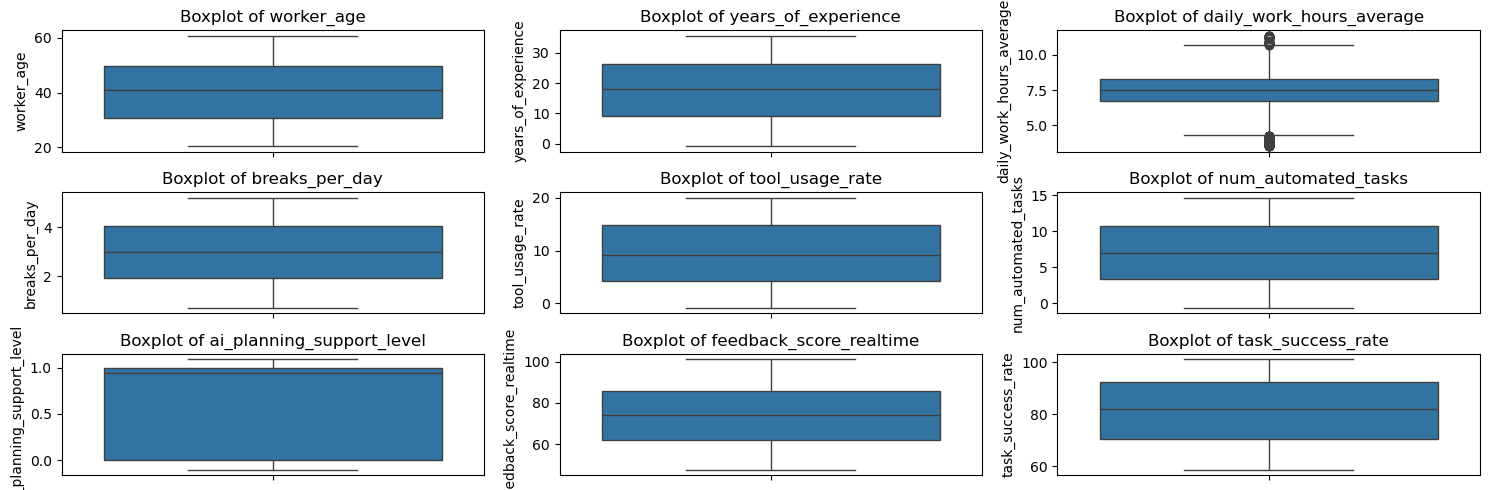

In [217]:
fig, axes = plt.subplots(3, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(combined.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

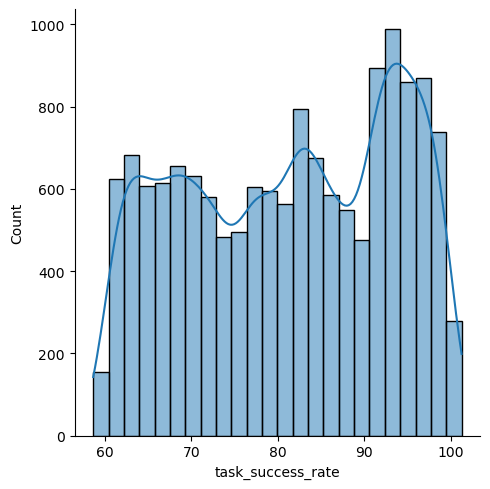

In [218]:
sns.displot(train['task_success_rate'], kde = True)

In [219]:
combined['workload_intensity'] = combined['daily_work_hours_average'] / (combined['breaks_per_day'] + 1)

In [220]:
combined['tool_efficiency'] = combined['tool_usage_rate'] * combined['num_automated_tasks']

In [221]:
combined['ai_assistance_factor'] = combined['ai_planning_support_level'] * combined['tool_usage_rate']

In [222]:
combined['manual_burden_index'] = (1 - combined['ai_planning_support_level']) * (1 - combined['tool_usage_rate'])

In [223]:
combined['break_ratio'] = combined['breaks_per_day'] / combined['daily_work_hours_average']

In [224]:
combined['interaction_1'] = combined['years_of_experience'] * combined['ai_planning_support_level']

In [225]:
combined['interaction_2'] = combined['tool_usage_rate'] * combined['daily_work_hours_average']

In [226]:
combined['interaction_3'] = combined['breaks_per_day'] * combined['feedback_score_realtime']

In [227]:
combined['work_support_index'] = (combined['ai_planning_support_level'] + combined['tool_usage_rate'] + combined['feedback_score_realtime']) / 3

In [228]:
newtrain = combined.iloc[0:15000, : ]
newtest = combined.iloc[15000: , : ]

In [229]:
newtest = newtest.drop('task_success_rate', axis = 1)

In [230]:
x = newtrain.drop('task_success_rate', axis = 1)
y = newtrain['task_success_rate']

In [231]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [232]:
models = {'Logistic Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(), 'CatBoost': CatBoostRegressor()}

In [233]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        cv_rmse = -cross_val_score(model, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
        results[name] = cv_rmse
    return results  

In [234]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 17
[LightGBM] [Info] Start training from score 81.410628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 17
[LightGBM] [Info] Start training from score 81.344283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 17
[LightGBM] [Info] Start trai

In [235]:
best_model_name = min(results, key = results.get)
best_model = models[best_model_name]

In [236]:
print(f"best model is {best_model_name} with rmse {results[best_model_name]}")

best model is Extra Tree with rmse 1.2842548473641362


In [237]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [238]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))

1.1407378250769853


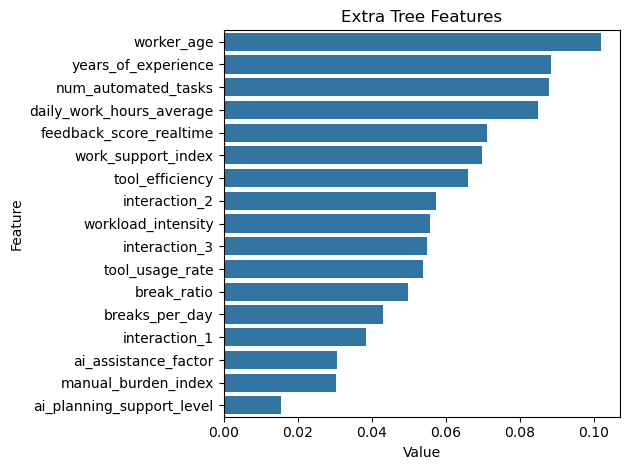

In [239]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, x.columns), reverse=True)[:20], columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(f'{best_model_name} Features')
plt.tight_layout()
plt.show()

In [241]:
x_train = newtrain.drop('task_success_rate', axis = 1)
y_train = newtrain['task_success_rate']
x_test = newtest
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [242]:
solution = pd.DataFrame({'task_success_rate': y_pred})
solution.head()

,task_success_rate
0,95.638622
1,83.558673
2,83.920122
3,96.637105
4,88.672726


In [243]:
solution.to_csv('Solution.csv', index = False)